# Homework 02 - Data from the Web

Before doing computing any statistics, the data have to be fetched from the IS Academia web page. The following code will retrieve all the records for Computer Science ("Informatique") students from years 2007-2008 to 2016-2017 and concatenate them together in a big DataFrame. To avoid querying the service too often, the data are stored in a file and can be loaded from there. We could also have asked IS Academia to return all the records for Computer Science instead of iterating on the links it returns, but this method also returns older records and take longer.

**Note that the current code won't fetch the data unless you uncomment the code a few cells below. By default, it will load the data from the cs_dump.pkl file.**

In [1]:
import requests
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
from scipy import stats
import urllib.parse
import re
import pandas as pd

In [2]:
def get_is_academia_page(page, params={}):
    """
        Return the content of a IS-Academia webpage as a string
    """
    
    BASE_URL = 'https://isa.epfl.ch/imoniteur_ISAP/'
    PAGES = {'filter': '!GEDPUBLICREPORTS.filter', 'results': '!GEDPUBLICREPORTS.html'}
    BASE_PARAMS = {'ww_i_reportmodel': '133685247', # Registered students by section and semester
                   'ww_i_reportModelXsl': '133685270'}
    
    # Check the validity of the `page` parameter
    if not isinstance(page, str) or page not in PAGES:
        allowed_pages = ', '.join(PAGES.keys())
        raise ValueError('page argument must be: {}'.format(allowed_pages))
    
    url = urllib.parse.urljoin(BASE_URL, PAGES[page]) # Create the URL
    r = requests.get(url, params={**BASE_PARAMS, **params}) # Python 3.5 syntax for merging dictionaries
    r.raise_for_status() # Raise an exception if we can't get the page

    return r.text

In [3]:
def construct_dict_from_select(soup, match_name):
    # Use a CSS selector to get the <option> tags that are child of
    # a <select> tag with the specified `name` attribute
    css_selector = 'select[name="{}"] > option'.format(match_name)
    option_tags = soup.select(css_selector)
    
    # Create a dictionary mapping the text to the internal ID used by IS-Acdemia
    return {tag.string: tag['value'] for tag in option_tags if tag.string}

In [4]:
# Use a strainer to parse only the <select> tags in the page
strainer = SoupStrainer('select')
page = get_is_academia_page('filter')
soup = BeautifulSoup(page, 'html.parser', parse_only=strainer)

# Create a dictionary mapping the departments ids
departments = construct_dict_from_select(soup, 'ww_x_UNITE_ACAD')
cs_department = departments['Informatique']
# Create a dictionary mapping the years ids
years = construct_dict_from_select(soup, 'ww_x_PERIODE_ACAD')

years

{'2007-2008': '978181',
 '2008-2009': '978187',
 '2009-2010': '978195',
 '2010-2011': '39486325',
 '2011-2012': '123455150',
 '2012-2013': '123456101',
 '2013-2014': '213637754',
 '2014-2015': '213637922',
 '2015-2016': '213638028',
 '2016-2017': '355925344'}

In [5]:
def parse_semesters_list(year_id, department_id):
    # HTTP parameters
    params = {'ww_b_list': 1,
              'ww_x_PERIODE_ACAD': year_id,
              'ww_x_UNITE_ACAD': department_id}
    
    page = get_is_academia_page('filter', params)
    strainer = SoupStrainer('a') # Only parse the <a> tags
    soup = BeautifulSoup(page, 'html.parser', parse_only=strainer)

    # Extract the ww_x_GPS id from the Javascript code in the `onclick` attribute of links
    def extract_id(tag):
        match = re.search('ww_x_GPS=(\d+)', tag['onclick'])
        if match is None: # Return None if there is no positive id associated with this link
            return None
        else:
            return match.group(1)

    # Create a dictionary mapping the semesters to their IDs
    return {tag.text: extract_id(tag) for tag in soup.find_all('a') if extract_id(tag) is not None}

In [6]:
# Create a dict mapping all CS semesters from all years to their internal ID used by IS-Academia
semester_ids = {}
for year_id in years.values():
    semester_ids.update(parse_semesters_list(year_id, cs_department))

semester_ids

{'Echange IN, 2007-2008, Semestre automne': '71454914',
 'Echange IN, 2007-2008, Semestre printemps': '71454935',
 'Echange IN, 2008-2009, Semestre automne': '117663512',
 'Echange IN, 2008-2009, Semestre printemps': '117663545',
 'Echange IN, 2009-2010, Semestre automne': '230302571',
 'Echange IN, 2009-2010, Semestre printemps': '230302592',
 'Echange IN, 2010-2011, Semestre automne': '357706512',
 'Echange IN, 2010-2011, Semestre printemps': '357706534',
 'Echange IN, 2011-2012, Semestre automne': '736316291',
 'Echange IN, 2011-2012, Semestre printemps': '736316313',
 'Echange IN, 2012-2013, Semestre automne': '1378335442',
 'Echange IN, 2012-2013, Semestre printemps': '1378335469',
 'Echange IN, 2013-2014, Semestre automne': '1650772948',
 'Echange IN, 2013-2014, Semestre printemps': '1650772975',
 'Echange IN, 2014-2015, Semestre automne': '1745516952',
 'Echange IN, 2014-2015, Semestre printemps': '1745516979',
 'Echange IN, 2015-2016, Semestre automne': '1897038293',
 'Echange 

In [7]:
# Returns a dataframe containing the list of students for a given semester
# or None if there isn't any table in the page
def get_people(semester_id):
    page = get_is_academia_page('results', {'ww_x_GPS': semester_id})
    
    # Parse the HTML table using Pandas
    frames = pandas.read_html(page, header=1)
    
    if frames is None or not frames: # Returns None if we can't get any dataframe
        return None
    
    df = frames[0]
    
    # Drop the last column which is empty (due to IS-Academia formatting)
    return df.drop(df.columns[-1], axis=1)

## Do not execute the cell below!
It gets a lot of pages from IS-Academia. Use the next cell to load the data from a pickle file instead.

In [8]:
#frames = []
#for semester, semester_id in semesters_ids.items():
#    df = get_people(semester_id)
#    
#    # Add a column containing the semester (if we can get the dataframe)
#    if df is not None:
#        df['semester'] = semester
#    frames.append(df)
#    
## Concatenate all semesters from all years
#df = pd.concat(frames)

## Load the data from a pickle file

In [9]:
df = pd.read_pickle('cs_dump.pkl')
#df.set_index(['semester', 'No Sciper'], inplace=True)
#df.sort_index(inplace=True)

Shorten the columns names

In [10]:
df.columns = ['title', 'name', 'orientation_ba', 'orientation_ma', 
              'specialization', 'filiere_opt', 'minor', 'status', 
              'exchange_type', 'exchange_school', 'sciper', 'semester']
df['semester'].head(1)

0    Informatique, 2007-2008, Master semestre 3
Name: semester, dtype: object

The semester column contains too much information: we split it in three columns. Also, do not keep a years range. Knowing only the first year of the cycle is sufficient, i.e. we know that a semester starting in 2007 will end in 2008.

In [11]:
# Take the 'semester' column and split it into 'section', 'years' and 'semester'
new_cols = pd.DataFrame(df['semester'], index=df.index)
cols = new_cols['semester'].apply(lambda x: pd.Series(x.split(', ')))
cols.columns = ['section', 'years', 'semester']
data = pd.concat([df.drop('semester', axis=1), cols], axis=1)

# Only keep the first year of the years range
data['year'] = data.years.apply(lambda x: int(x.split('-')[0]))

data[['sciper', 'title', 'name', 'section', 'semester', 'years', 'year']].head(3)

,sciper,title,name,section,semester,years,year
0,154419,Monsieur,Benda Lukas,Informatique,Master semestre 3,2007-2008,2007
1,153742,Monsieur,Bozzo Vincent,Informatique,Master semestre 3,2007-2008,2007
2,153664,Monsieur,Brandinu Guillaume,Informatique,Master semestre 3,2007-2008,2007


## Exercise 1

We made the following assumptions:
1. A semester corresponds to 6 months of work
2. A student taking semester 6 eventually got his bachelor
3. A student in semester 5 in 2016-2017 who already did semester 6 will finish this semester

It is possible that somebody finished its bachelor in semester 5, but this is only allowed if that person also did semester 6 at least once. That's why we need both data from semesters 5 and 6.

In [12]:
# Get all records of people in BA1, BA5 and BA6
ba1_sem = data[data.semester == 'Bachelor semestre 1']
ba5_sem = data[data.semester == 'Bachelor semestre 5']
ba6_sem = data[data.semester == 'Bachelor semestre 6']

People who are doing both bachelor and master degrees at EPFL are allowed to take a one year break between the two in certain cases. Theses semesters must not be counted.

In [13]:
# Drop the records for BA5 and BA6 with status 'Congé'
ba5_sem = ba5_sem[ba5_sem.status != 'Congé']
ba6_sem = ba6_sem[ba6_sem.status != 'Congé']

Build a DataFrame, which has the student sciper as index and the year it started its bachelor as only column.

In [14]:
# Check for oldest records
started = ba1_sem[['sciper', 'year']].groupby('sciper').min()
started.columns = ['started']
started.head(3)

,started
sciper,
147008,2008
161212,2009
169569,2007


Do the same for the ending year. Note that we have to do this for both semesters 5 and 6.

In [15]:
# Check for most recent records
ba5_ended = ba5_sem[['sciper', 'year']].groupby('sciper').max()
ba5_ended.columns = ['5']

ba6_ended = ba6_sem[['sciper', 'year']].groupby('sciper').max()
ba6_ended.columns = ['6']

Do an inner join to keep only students who did BA5 and BA6, keep the most recent year. Note that we concat BA6 before BA5, because max() returns the first result in case of equality.

In [16]:
ended = pd.concat([ba6_ended, ba5_ended], axis=1, join='inner')
ended['ended'] = ended.max(axis=1)                              # When was the most recent record found ?
ended['semester'] = pd.to_numeric(ended.idxmax(axis=1))         # At what semester did the student finish ?
ended.drop(['5', '6'], axis=1, inplace=True)                    # Drop unused columns
ended.head(3)

,ended,semester
sciper,,
153762,2007,6
159516,2007,6
159998,2007,6


Now that we know when students started and finished their bachelor, we can join the two DataFrame (using an inner join) to keep only those who did bachelor semester 1 and bachelor semester 6.

In [17]:
# Concat on the index (sciper)
agg = pd.concat([started, ended], axis=1, join='inner')
agg.head(3)

,started,ended,semester
sciper,,,
169569,2007,2009,6
169795,2007,2011,5
171195,2007,2009,6


The bachelor duration for each student can be computed. If the student finished during semester 5, then 6 months have to be subtracted.

In [18]:
agg['duration'] = 12*(agg.ended - agg.started + 1) - 6*(agg.semester % 2)

Let's add the students genders to the table

In [19]:
gender = data[['sciper', 'title']].drop_duplicates()
gender.set_index('sciper', inplace=True)
agg = pd.concat([agg, gender], axis=1, join='inner')
agg.head(3)

,started,ended,semester,duration,title
sciper,,,,,
174905,2007,2011,6,60,Monsieur
179406,2007,2010,6,48,Monsieur
179428,2007,2010,6,48,Monsieur


And the average duration by gender can now be computed

In [20]:
agg[['title', 'duration']].groupby('title').mean()

,duration
title,
Madame,40.500000
Monsieur,44.580882


To find if the difference in average is statistically significant, we run a T-Test

In [21]:
s1 = agg[agg['title'] == 'Monsieur']['duration'].tolist()
s2 = agg[agg['title'] == 'Madame']['duration'].tolist()

t_stat, p_val = stats.ttest_ind(s1, s2)
p_val

0.04603072654598047

Because p\_val < 0.05, we reject the null hypothesis that the two groups have equal averages. We conclude that at the 95% confidence level males take on average longer to finish their bachelor degree compared to females.

## Exercise 2
We know that to finish his Master, a student must do the following:
1. 2 semesters of courses (MA1 + MA2)
2. One more semester (MA3) ff he has a specialization or a minor.
3. An internship. He can do it during the summer holidays or during a semester.
4. Finish his studies by doing a Master thesis during a semester.

Because of (4), the exercise seems straigthforward: compute the distance in months between MA1 and the thesis semester. Unfortunately, IS Academia is missing a lot of data regarding the Master theses. Indeed, it only shows a few people doing a thesis, way below the real number. This makes the task more difficult.

Again because of (4), we know that the students must finish by a Master thesis, i.e. we can add 12 months to all students who finished their credits and did a stage. The problem is that some students did their internship during the summer holidays. Some of them also combined their Master thesis with the internship.

This leaves us with 2 options:
1. Compute only the distance in months for a student to finish his courses
2. Use the Master thesis as the ending year, but them work with a much smaller set of data

For now, let's compute the time students took to finish the courses, without taking the Master thesis or internship into account. The beginning is very similar to what we did for the bachelor data set.

In [22]:
# Get all records of people in MA1, MA2 and MA3
ma1_sem = data[data.semester == 'Master semestre 1']
ma2_sem = data[data.semester == 'Master semestre 2']
ma3_sem = data[data.semester == 'Master semestre 3']

Find when students started MA1 or MA2, because they can start the Master during the spring semester.

In [23]:
# Check for the oldest records
started = pd.concat([ma1_sem, ma2_sem])[['sciper', 'year', 'semester']].groupby('sciper').min()
started['semester'] = pd.to_numeric(started.semester.apply(lambda x: x.split(' ')[2]))
started.columns = ['started', 'semester_start']
started.head(3)

,started,semester_start
sciper,,
128911,2007,2
129093,2007,2
129326,2007,2


Find when they finished taking courses. They can finish during MA2 or MA3, but not during MA1.

In [24]:
# Check for most recent records
ma2_ended = ma2_sem[['sciper', 'year']].groupby('sciper').max()
ma2_ended.columns = ['ended']
ma2_ended['semester_end'] = 2

ma3_ended = ma3_sem[['sciper', 'year']].groupby('sciper').max()
ma3_ended.columns = ['ended']
ma3_ended['semester_end'] = 3

The possible ending dates (MA2 or MA3) are now concatenated vertically in a single table. The years are sorted (descending) and only the most recent year is chosen for each sciper.

In [25]:
# Merge vertically and take one semester per sciper (descending years)
ended = pd.concat([ma3_ended, ma2_ended])
ended = ended.sort_values(by='ended', ascending=False)
ended = ended.groupby(ended.index).first()
ended.head(3)

,ended,semester_end
sciper,,
128911,2007,2
129093,2007,3
129326,2007,3


The starting and ending years are now concatenated together

In [26]:
agg = pd.concat([started, ended], axis=1, join='inner')
agg.head(3)

,started,semester_start,ended,semester_end
sciper,,,,
128911,2007,2,2007,2
129093,2007,2,2007,3
129326,2007,2,2007,3


We are also interested in the specialization or minor they did. Let's build 2 tables, one with the specializations and one with the minors. They are indexed by sciper.

In [27]:
# Find students who did a minor
minor = data[['sciper', 'minor']][~data.minor.isnull()]
minor.drop_duplicates('sciper', inplace=True)
minor.set_index('sciper', inplace=True)
minor.head(3)

,minor
sciper,
160391,"Mineur en Management, technologie et entrepren..."
172257,"Mineur en Management, technologie et entrepren..."
153642,"Mineur en Management, technologie et entrepren..."


In [28]:
# Find students who did a specialization
spec = data[['sciper', 'specialization']][~data.specialization.isnull()]
spec.drop_duplicates('sciper', inplace=True)
spec.set_index('sciper', inplace=True)
spec.head(3)

,specialization
sciper,
154419,"Signals, Images and Interfaces"
153664,"Signals, Images and Interfaces"
159852,Internet computing


And they can be merged with the previous table. Note that this time, pd.merge() was used insted of pd.concat(). This is because a left outer join had to be done, and concat cannot do it.

In [29]:
# Join with minor and specialization
agg = agg.merge(minor, left_index=True, right_index=True, how='left', copy=False)
agg = agg.merge(spec, left_index=True, right_index=True, how='left', copy=False)
agg.head(5)

,started,semester_start,ended,semester_end,minor,specialization
sciper,,,,,,
128911,2007,2,2007,2,NaN,Internet computing
129093,2007,2,2007,3,NaN,NaN
129326,2007,2,2007,3,NaN,NaN
146330,2007,1,2008,3,NaN,NaN
146742,2008,1,2012,3,NaN,"Signals, Images and Interfaces"


Compute the time students took to finish their courses. We remove six months if the student ended during MA2 or if he started during MA2.

In [30]:
agg['duration'] = 12*(agg.ended - agg.started + 1) - 6*(agg.semester_end % 2) - 6*((agg.semester_start + 1) % 2)
agg.head(3)

,started,semester_start,ended,semester_end,minor,specialization,duration
sciper,,,,,,,
128911,2007,2,2007,2,NaN,Internet computing,6
129093,2007,2,2007,3,NaN,NaN,0
129326,2007,2,2007,3,NaN,NaN,0


Remove the students that did less than 12 months, as they cannot have finished yet.

In [31]:
agg = agg[agg.duration >= 12]

We also have to remove people that are doing a specialization or a minor but that only have been at EPFL for 12 months or less.

In [32]:
agg = agg[(agg.minor.isnull() & agg.specialization.isnull()) | (agg.duration > 12)]

On average, they took, in months:

In [33]:
general_mean = agg.duration.mean()
general_mean

19.032851511169515

We can also compute the average stay for students doing a specialization.

In [34]:
spec_mean = agg['duration'][~agg.specialization.isnull()].mean()
spec_mean

22.102564102564102

Or more precisely, per specialization:

In [35]:
agg[['specialization', 'duration']][~agg.specialization.isnull()].groupby('specialization').mean()

,duration
specialization,
Biocomputing,24.000000
Computer Engineering - SP,19.894737
Computer Science Theory,18.000000
Data Analytics,18.000000
Foundations of Software,22.700000
Information Security - SP,19.714286
Internet Information Systems,18.000000
Internet computing,22.133333
Service science,19.500000


Note that we found 5 students who were registered in multiple specialization. For them, only one specialization was taken into account. Now, let's run a T-test to check if the averages are statistically significant

In [36]:
spec_sep = agg[['specialization', 'duration']][~agg.specialization.isnull()].groupby('specialization')
for d in spec_sep:
    samples = d[1].duration.tolist()
    if len(samples) > 1:
        t_stat, p_val = stats.ttest_1samp(samples, general_mean)
        print('{0} against population mean:\n\t{1}\n'.format(d[0], p_val))
        

Biocomputing against population mean:
	0.24706536431305895

Computer Engineering - SP against population mean:
	0.4142934029667261

Data Analytics against population mean:
	0.0

Foundations of Software against population mean:
	4.813731354989613e-06

Information Security - SP against population mean:
	0.5606390404385315

Internet computing against population mean:
	1.6842323417170528e-06

Service science against population mean:
	0.7758595197934844

Signals, Images and Interfaces against population mean:
	0.003471626556482594

Software Systems against population mean:
	0.20971204804678492



With this output, we can see that the averages are only statistically significant for: 
1. Data Analytics specializations.
2. Foundations of Software
3. Internet computing
4. Signals, Images and Interfaces

For the others, we cannot reject the null hypothesis that they have the same average as the global population. Also note that this can be due to the fact that some specializations only have a few entries:

In [37]:
spec_sep.count()

,duration
specialization,
Biocomputing,4
Computer Engineering - SP,19
Computer Science Theory,1
Data Analytics,4
Foundations of Software,60
Information Security - SP,7
Internet Information Systems,1
Internet computing,90
Service science,4


As said earlier, we could have taken the year difference between the MA1 semester and the Master project semester. This can be done with the following code, which is a lot similar to the previous ones.

In [38]:
# Get all records of people in MA1, MA2 and MA3
ma1_sem = data[data.semester == 'Master semestre 1']
ma2_sem = data[data.semester == 'Master semestre 2']
pdm_sem = data[data.semester.isin(['Projet Master printemps', 'Projet Master automne'])]

# Check for the oldest records
started = pd.concat([ma1_sem, ma2_sem])[['sciper', 'year', 'semester']].groupby('sciper').min()
started['semester'] = pd.to_numeric(started.semester.apply(lambda x: x.split(' ')[2]))
started.columns = ['started', 'semester_start']

# Check for most recent records
ended = pdm_sem[['sciper', 'year', 'semester']].groupby('sciper').max()
ended['semester'] = ended.semester.apply(lambda x: x.split(' ')[2])
ended.columns = ['ended', 'semester_end']

# Build the DataFrame
agg_mp = pd.concat([started, ended], axis=1, join='inner')

# Compute the total duration
agg_mp['duration'] = 12*(agg_mp.ended - agg_mp.started + 1) - 6*((agg_mp.semester_start + 1) % 2)
agg_mp.ix[agg_mp.semester_end == 'automne', 'duration'] -= 6

# Add the specialization
spec = data[['sciper', 'specialization']][~data.specialization.isnull()]
spec.drop_duplicates('sciper', inplace=True)
spec.set_index('sciper', inplace=True)

agg_mp = agg_mp.merge(spec, left_index=True, right_index=True, how='left', copy=False)

print('{0} rows'.format(len(agg_mp)))
agg_mp.head(3)

114 rows


,started,semester_start,ended,semester_end,duration,specialization
sciper,,,,,,
146742,2008,1,2010,printemps,36,"Signals, Images and Interfaces"
154573,2007,1,2009,printemps,36,Biocomputing
159516,2008,1,2009,printemps,24,NaN


The duration is more precise, but the subset only contains 113 students. The average duration is now:

In [39]:
general_mean_mp = agg_mp['duration'].mean()
general_mean_mp

25.736842105263158

And per specialization:

In [40]:
agg_mp[['specialization', 'duration']][~agg_mp.specialization.isnull()].groupby('specialization').mean()

,duration
specialization,
Biocomputing,36.000000
Computer Engineering - SP,30.000000
Foundations of Software,30.857143
Information Security - SP,30.000000
Internet computing,28.200000
Service science,30.000000
"Signals, Images and Interfaces",30.000000
Software Systems,30.000000


And this time the T-test returns:

In [41]:
spec_sep = agg_mp[['specialization', 'duration']][~agg_mp.specialization.isnull()].groupby('specialization')
for d in spec_sep:
    samples = d[1].duration.tolist()
    if len(samples) > 1:
        t_stat, p_val = stats.ttest_1samp(samples, general_mean_mp)
        print('{0} against population mean:\n\t{1}\n'.format(d[0], p_val))

Computer Engineering - SP against population mean:
	0.0

Foundations of Software against population mean:
	0.1442644317399339

Information Security - SP against population mean:
	0.0

Internet computing against population mean:
	0.08658313994806686

Signals, Images and Interfaces against population mean:
	0.3435428722367828

Software Systems against population mean:
	0.0



The averages that are statistically significant, according to the test, are:
1. Computer Engineering - SP
2. Information Security
3. Software Systems

Because their p-value is < 0.05. For them, we conclude that students took longer, on average, to finish their master compared to the global average. Biocomputing and Service science are not shown, because they only contain 1 sample. Other specialization also only have a small number of samples, as shown below.

In [42]:
agg_mp[['specialization', 'duration']][~agg_mp.specialization.isnull()].groupby('specialization').count()

,duration
specialization,
Biocomputing,1
Computer Engineering - SP,2
Foundations of Software,7
Information Security - SP,2
Internet computing,10
Service science,1
"Signals, Images and Interfaces",3
Software Systems,2


## Bonus exercise

BONUS: perform the gender-based study also on the Master students, as explained in 1. Use scatterplots to visually identify changes over time. Plot males and females with different colors -- can you spot different trends that match the results of your statistical tests?

We can use the table of the aggregates constructed above and drop some unnecessary columns.


In [43]:
agg.drop(["minor", "semester_start", "semester_end", "specialization"], axis=1, inplace=True)
agg.head(5)

,started,ended,duration
sciper,,,
146330,2007,2008,18
146742,2008,2012,54
146929,2007,2007,12
147008,2011,2012,18
152232,2007,2008,18


Next we add the column for titles in order to define genders. The table for gender was found earlier.

In [44]:
agg = pd.concat([agg, gender], axis=1, join='inner')
agg.head(3)

,started,ended,duration,title
sciper,,,,
153324,2007,2008,12,Monsieur
154503,2007,2008,12,Monsieur
184772,2011,2012,18,Monsieur


Next we see the average duration of a master's degrees by gender. The means look very similar.

In [45]:
agg[['title', 'duration']].groupby('title').mean()

,duration
title,
Madame,18.941176
Monsieur,19.047041


Lets see the results of a T-test.

In [46]:
s1 = agg[agg['title'] == 'Monsieur']['duration'].tolist()
s2 = agg[agg['title'] == 'Madame']['duration'].tolist()

t_stat, p_val = stats.ttest_ind(s1, s2)
p_val

0.86759551083982134

The p-value is higher than 0.05 which means, that the two means for durations by gender are not significantly different, i.e. the null hypothesis of similar means remains.

It would be interesting to see how many males and females actually finished their master's degree. As we see from the counts below, the ratio is around 6 males per 1 female. The maximum duration for males is higher at 54 months when compared with 42 months as a maximum duartion for females. The minimum is 12 months for both genders.

In [47]:
agg[['title', 'duration']].groupby('title').describe()

duration
title                     
Madame   count  102.000000
         mean    18.941176
         std      5.894827
         min     12.000000
         25%     18.000000
         50%     18.000000
         75%     18.000000
         max     42.000000
Monsieur count  659.000000
         mean    19.047041
         std      5.976848
         min     12.000000
         25%     18.000000
         50%     18.000000
         75%     18.000000
         max     54.000000

We can compute the average time to finish the master's degree by gender and the starting year.

In [48]:
malesAveragesByYear = agg[['title', 'started', 'duration']][agg.title == "Monsieur"].groupby('started').mean()
femalesAveragesByYear = agg[['title','started', 'duration']][agg.title == "Madame"].groupby('started').mean()
averagesByYear = pd.concat([malesAveragesByYear, femalesAveragesByYear], axis=1, join='inner')
averagesByYear.columns = ['males', 'females']
averagesByYear

,males,females
started,,
2007,18.095238,15.000000
2008,17.200000,17.000000
2009,18.782609,18.000000
2010,19.350000,20.571429
2011,19.815789,19.764706
2012,19.826087,21.272727
2013,20.240964,19.714286
2014,21.164835,19.846154
2015,16.471698,16.714286


Next we create a histogram to better view the differences in average duration of a master's degree between females and males.

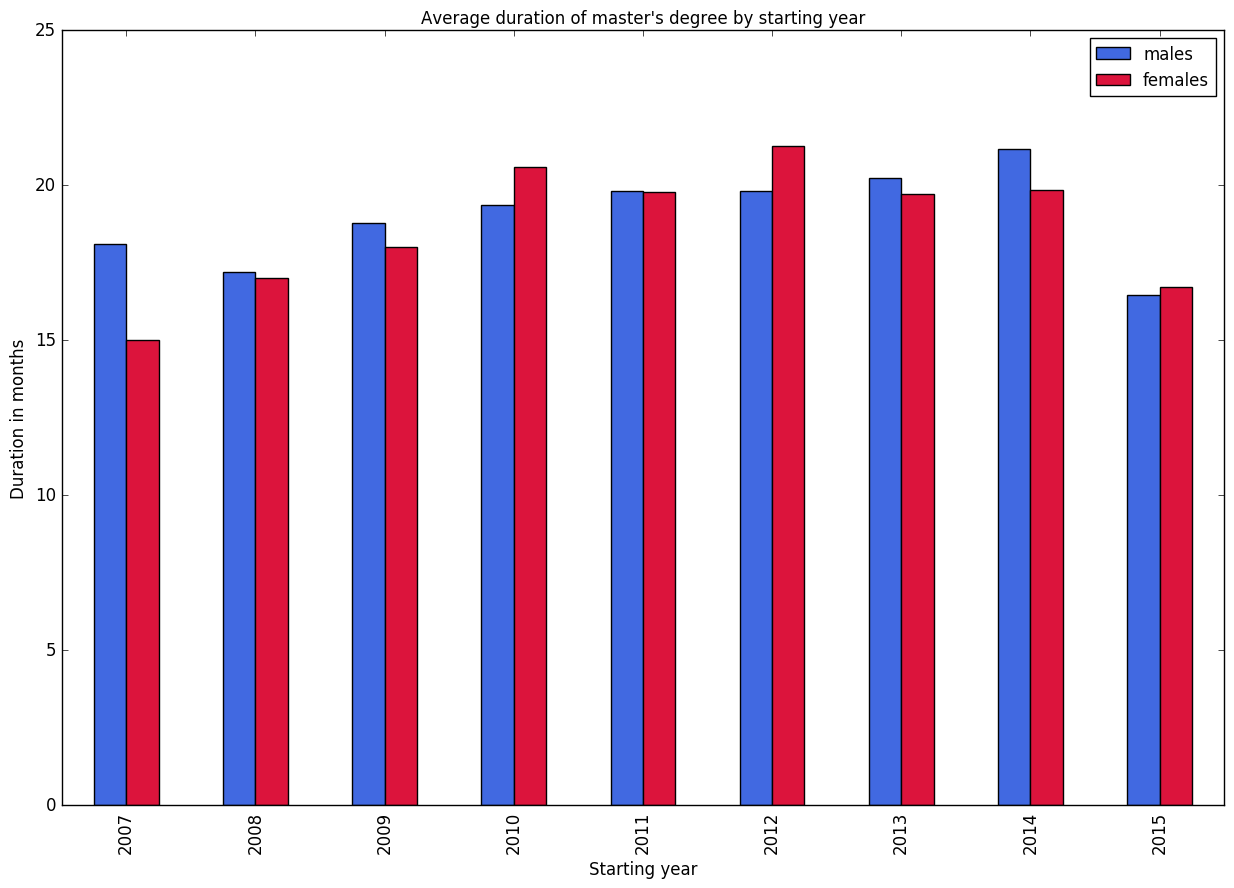

In [49]:
import matplotlib.pyplot as plt
ax = averagesByYear.plot(kind='bar', title ="Average duration of master's degree by starting year",figsize=(15,10),legend=True, fontsize=12, color=['royalblue', 'crimson'])
ax.set_xlabel("Starting year",fontsize=12)
ax.set_ylabel("Duration in months",fontsize=12)

plt.show()

From the above plot we see that for most of the years the time to finish a master's degree has been similar for females and males, however from the students who started in 2010 and 2012 females took slightly longer to finish. For the starting year of 2007 and 2014 we see that males took longer to finish their degree. For all the other years the differences are looking small. Also note that for year 2015-2016, the average duration is smaller. This is because some students that started in 2015 didn't finish their Master yet, but the records for their next semesters are not available yet.